-------
-------

# PSF size/ellipticity as function of RA, DEC

Display of large areas:

* Circular area with diameter of 1 degree. PSF_size from object catalogue (from coadded images) using TAP.

* Full visit (189 detectors). PSF_size from individual catalogue and using method getPsf().computeShape(point).getTraceRadius().

-------

In [1]:
# Import general python packages
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas
from pandas.testing import assert_frame_equal
from astropy import units as u
from astropy.coordinates import SkyCoord

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service, retrieve_query

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
import lsst.afw.table as afwTable
from lsst.daf.butler import Butler # access to LSST data products
import lsst.daf.base as dafBase
afwDisplay.setDefaultBackend('matplotlib')
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius
from lsst.afw.cameraGeom import utils as cgUtils
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms
from lsst.obs.lsst.cameraTransforms import ampPixelToCcdPixel
from lsst.afw.cameraGeom import FIELD_ANGLE, FOCAL_PLANE, PIXELS
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom


# To ignore some kinds of warnings
import warnings
from astropy.units import UnitsWarning

-------

## 1. Circular area with diameter of 1 degree. PSF_size from object catalogue using TAP.



In [2]:
service = get_tap_service()
assert service is not None
assert service.baseurl == "https://data.lsst.cloud/api/tap"

In [3]:
my_ra_deg = 55.745834
my_dec_deg = -32.269167

coord = SkyCoord(ra = my_ra_deg*u.degree, dec = my_dec_deg*u.degree, frame='icrs')
radius = 0.5 * u.deg

query = "SELECT obj.objectId, obj.ra, obj.dec, obj.mag_g, obj.mag_i, obj.mag_r, obj.mag_u, obj.mag_y, obj.mag_z, "\
        "obj.Ixx_pixel, obj.Ixx_pixel_g, obj.Ixx_pixel_i, obj.Ixx_pixel_r, obj.Ixx_pixel_u, "\
        "obj.Ixx_pixel_y, obj.Ixx_pixel_z, obj.IxxPSF_pixel, obj.IxxPSF_pixel_g, obj.IxxPSF_pixel_i, " \
        "obj.IxxPSF_pixel_r, obj.IxxPSF_pixel_u, obj.IxxPSF_pixel_y, obj.IxxPSF_pixel_z, obj.Ixy_pixel, "\
        "obj.Ixy_pixel_g, obj.Ixy_pixel_i, obj.Ixy_pixel_r, obj.Ixy_pixel_u, obj.Ixy_pixel_y, " \
        "obj.Ixy_pixel_z, obj.IxyPSF_pixel, obj.IxyPSF_pixel_g, obj.IxyPSF_pixel_i, " \
        "obj.IxyPSF_pixel_r, obj.IxyPSF_pixel_u, obj.IxyPSF_pixel_y, obj.IxyPSF_pixel_z, " \
        "obj.Iyy_pixel, obj.Iyy_pixel_g, obj.Iyy_pixel_i, obj.Iyy_pixel_r, obj.Iyy_pixel_u, " \
        "obj.Iyy_pixel_y, obj.Iyy_pixel_z, obj.IyyPSF_pixel, obj.IyyPSF_pixel_g, obj.IyyPSF_pixel_i, " \
        "obj.IyyPSF_pixel_r, obj.IyyPSF_pixel_u, obj.IyyPSF_pixel_y, obj.IyyPSF_pixel_z," \
        "obj.tract, obj.patch, " \
        "obj.extendedness, obj.good, obj.clean, " \
        "truth.mag_r as truth_mag_r, truth.match_objectId, "\
        "truth.flux_g, truth.flux_r, truth.flux_i, truth.truth_type, " \
        "truth.match_sep, truth.is_variable " \
        "FROM dp01_dc2_catalogs.object as obj " \
        "JOIN dp01_dc2_catalogs.truth_match as truth " \
        "ON truth.match_objectId = obj.objectId " \
        "WHERE CONTAINS(POINT('ICRS', obj.ra, obj.dec),CIRCLE('ICRS', " \
        + str(coord.ra.value) + ", " + str(coord.dec.value) + ", " \
        + str(radius.value) + " )) = 1 " \
        "AND truth.match_objectid >= 0 "\
        "AND obj.extendedness = 0 "\
        "AND truth.is_good_match = 1"

results = service.search(query).to_table().to_pandas()

In [4]:
max(results['extendedness'])

0.0

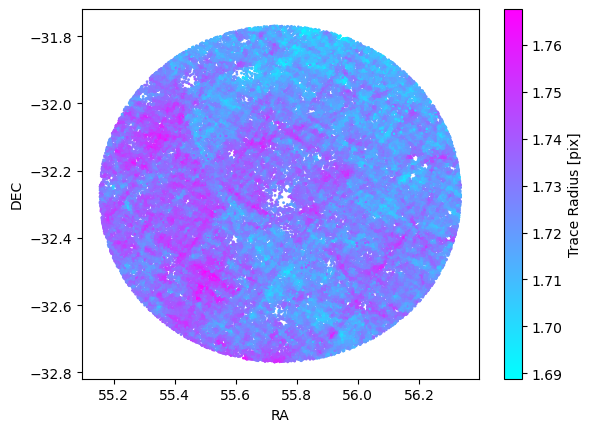

In [5]:
ra = results['ra']
dec = results['dec']
size_i = np.sqrt((results["IxxPSF_pixel_i"] + results["IyyPSF_pixel_i"]) / 2.)

plt.xlabel('RA')
plt.ylabel('DEC')
plt.scatter(ra, dec, c=size_i, s=1, cmap='cool')
colorbar = plt.colorbar(label='Trace Radius [pix]')

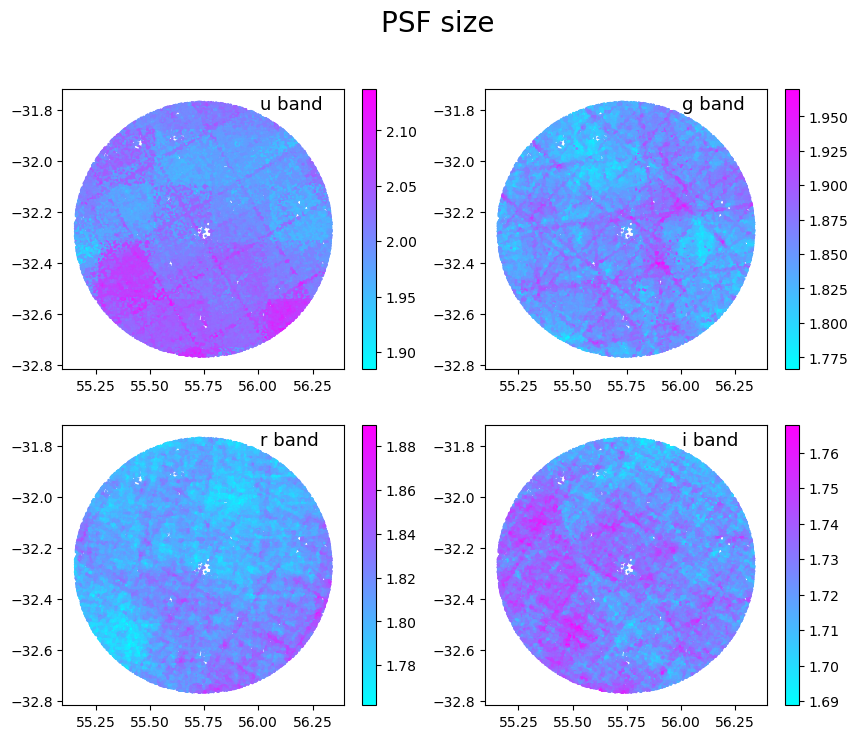

In [6]:
ra = results['ra']
dec = results['dec']

def PSF_size(band):
    return np.sqrt((results["IxxPSF_pixel_" + band] + results["IyyPSF_pixel_" + band]) / 2.)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("PSF size", fontsize=20)

for i,b in enumerate("ugri"):
    if i <= 1: j=0
    else: j=1
    sc = ax[j,i%2].scatter(ra, dec, c = PSF_size(b), s = 1, cmap = 'cool')
    plt.colorbar(sc, ax = ax[j,i%2])
    plt.text(0.7, 0.93, b + " band", color = 'k', fontsize=13, transform=ax[j,i%2].transAxes)


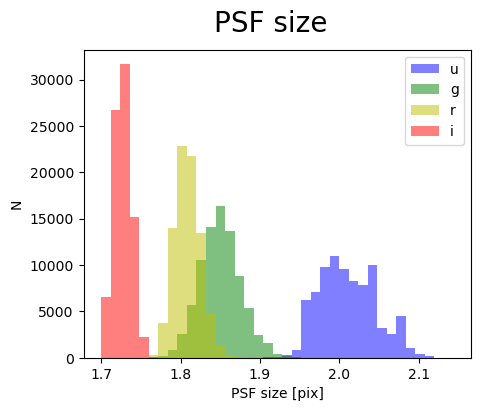

In [7]:
bins = np.arange(1.7, 2.15, 0.012)

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("PSF size", fontsize=20)

col = {"u": "b", "g": "g", "r": "y", "i":"r"}
for i,b in enumerate("ugri"):
    ax.hist(PSF_size(b), bins, alpha=0.5, color = col[b], label=b)

ax.set_xlabel('PSF size [pix]')
ax.set_ylabel('N')
plt.legend()

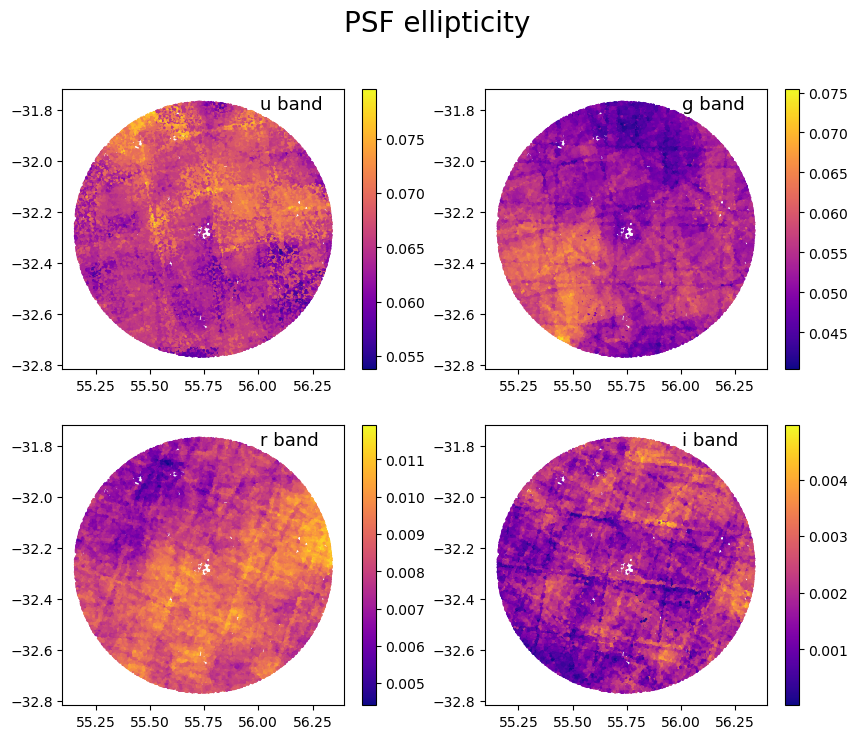

In [8]:
def ellipticity(band):
    i_xx = results["IxxPSF_pixel_" + band]
    i_yy = results["IyyPSF_pixel_" + band]
    i_xy = results["IxyPSF_pixel_" + band]
    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    return np.sqrt(e1**2 + e2**2)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("PSF ellipticity", fontsize=20)

for i,b in enumerate("ugri"):
    if i <= 1: j=0
    else: j=1
    sc = ax[j,i%2].scatter(ra, dec, c = ellipticity(b), s = 1, cmap = 'plasma')
    plt.colorbar(sc, ax = ax[j,i%2])
    plt.text(0.7, 0.93, b + " band", color = 'k', fontsize=13, transform=ax[j,i%2].transAxes)


-------

## 2. Full visit (189 detectors). 

#### 2.1 Display in pixels / focal plane.  Only point sources (objects with extendedness == 0).

_can be done using only stars used to construct PSF model_

PSF_size using _getPsf().computeShape(point).getTraceRadius()_ with point coordinates extracted from source catalogue. 

In [9]:
repo = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(repo, collections=collection)

In [10]:
def plot_FullVisit(visit,n_ccds):
    x, y, psf_size = [],[],[]
    
    for det in range(n_ccds):
        dataId = {'visit':visit,'detector': det} 
        ccd = butler.get('calexp', **dataId)
        src = butler.get('src', **dataId)
    
        origin = ccd.getWcs().getPixelOrigin() #RA,DEC
        ccdBox = geom.Box2D(ccd.getBBox())
        corners_PIX = ccdBox.getCorners()
        corners_FP = [ccd.getDetector().transform(pixelPos, cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE) for pixelPos in corners_PIX]
        corners = [(c.getX()*100, c.getY()*100) for c in corners_FP]
        x_ccdShift = corners[0][0]
        y_ccdShift = corners[0][1]
        
        ################ PSF ################
        psf = ccd.getPsf()
        #point_sources = src[src['calib_psf_used'] == True]
        point_sources = src[src['base_ClassificationExtendedness_value'] == 0]
    
        for i in range(len(point_sources)):
            point = point_sources[i].getCentroid()
            shape_psf = psf.computeShape(point)
            x.append(point[0] + x_ccdShift)
            y.append(point[1] + y_ccdShift)
            psf_size.append(shape_psf.getTraceRadius())
            
    return np.asarray(x),np.asarray(y), np.asarray(psf_size)       


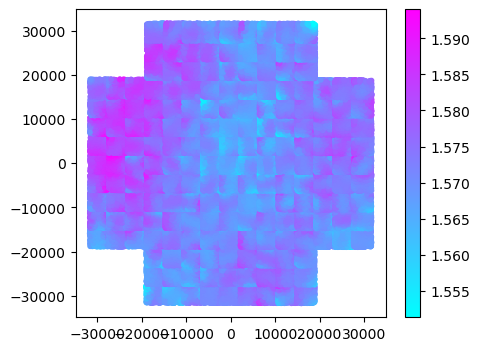

In [11]:
x, y, psf_size = plot_FullVisit(1169217,189)
fig= plt.figure(figsize=(5,4))
ax = plt.gca()

sc = ax.scatter(x, y, c=psf_size, s=10, cmap='cool')
plt.colorbar(sc, ax = ax)

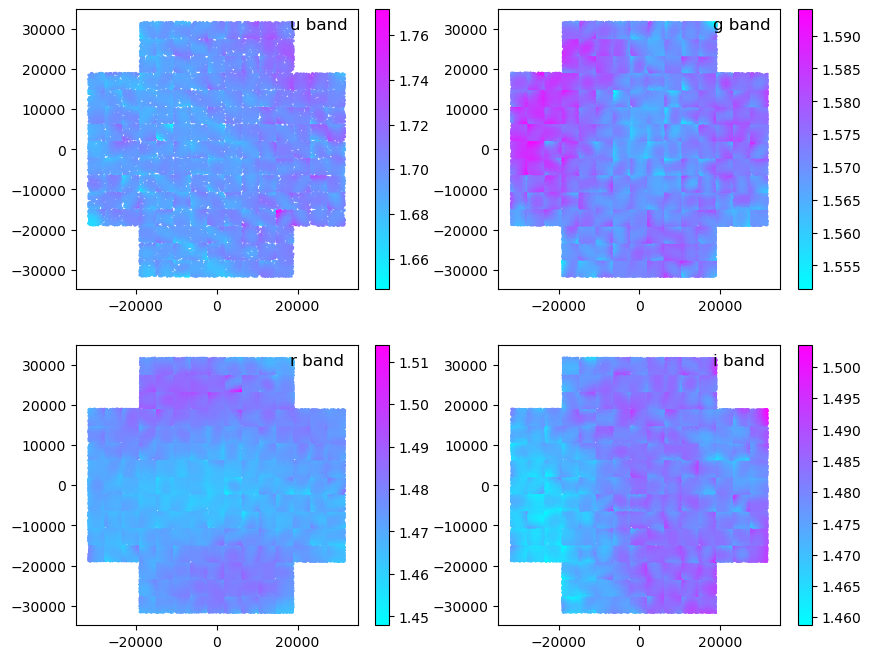

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i,v in enumerate([760255, 1169217, 908959, 951283]):
    if i <= 1: j=0
    else: j=1
    
    dataId = {'visit':v,'detector': 0} 
    ccd = butler.get('calexp', **dataId)
    band = ccd.getFilter().bandLabel
    
    x, y, psf_size = plot_FullVisit(v,189)
    sc = ax[j,i%2].scatter(x, y, c = psf_size, s = 1, cmap = 'cool')
    plt.colorbar(sc, ax = ax[j,i%2])
    plt.text(0.76, 0.93, band + " band", color = 'k', fontsize=12, transform=ax[j,i%2].transAxes) 


#### 2.2 Display in RADEC. Only point sources (objects with extendedness == 0).

PSF_size using _getPsf().computeShape(point).getTraceRadius()_ with point coordinates extracted from source catalogue. 

In [13]:
def FullVisit_RADEC(visit,n_ccds):
    ra, dec, psf_size = [],[],[]
    
    for det in range(n_ccds):
        dataId = {'visit':visit,'detector': det} 
        ccd = butler.get('calexp', **dataId)
        src = butler.get('src', **dataId)
    
        ################ PSF ################
        psf = ccd.getPsf()
        #point_sources = src[src['calib_psf_used'] == True]
        point_sources = src[src['base_ClassificationExtendedness_value'] == 0]
    
        for i in range(len(point_sources)):
            ra.append(point_sources[i]['coord_ra'])
            dec.append(point_sources[i]['coord_dec'])
            point = point_sources[i].getCentroid()
            shape_psf = psf.computeShape(point)
            psf_size.append(shape_psf.getTraceRadius())
            
    return np.asarray(ra),np.asarray(dec), np.asarray(psf_size)


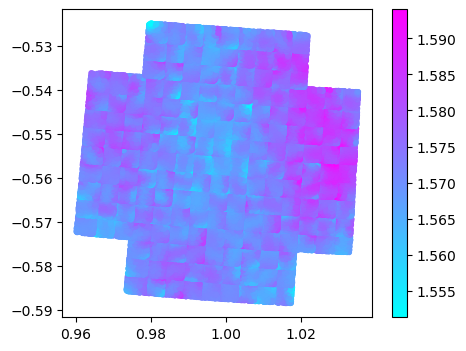

In [14]:
ra, dec, psf_size = FullVisit_RADEC(1169217,189)
fig= plt.figure(figsize=(5,4))
ax = plt.gca()

sc = ax.scatter(ra, dec, c=psf_size, s=10, cmap='cool')
plt.colorbar(sc, ax = ax)

#### 2.3 Display in RADEC. Only point sources (objects with extendedness == 0).

Point coordinates and PSF_size extracted from source catalogue. 

In [15]:
def fullVisit_RADEC_Only_catalog(visit,n_ccds):
    ra, dec, psf_size = [],[],[]
    
    for det in range(n_ccds):
        dataId = {'visit':visit,'detector': det} 
        #ccd = butler.get('calexp', **dataId)
        src = butler.get('src', **dataId)
        #point_sources = src[src['calib_psf_used'] == True]
        point_sources = src[src['base_ClassificationExtendedness_value'] == 0]
    
        for i in range(len(point_sources)):
            ra.append(point_sources[i]['coord_ra'])
            dec.append(point_sources[i]['coord_dec'])
            psf_size.append(np.sqrt((point_sources[i]['base_SdssShape_psf_xx'] + point_sources[i]['base_SdssShape_psf_yy']) / 2.))
        
    return np.asarray(ra),np.asarray(dec), np.asarray(psf_size) 


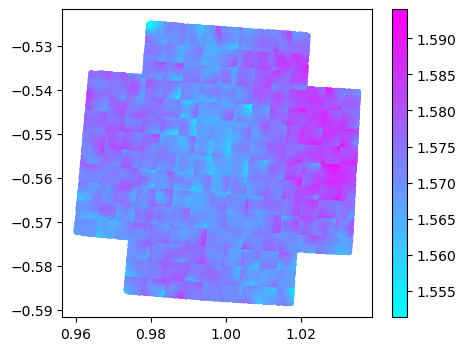

In [16]:
ra, dec, psf_size = fullVisit_RADEC_Only_catalog(1169217,189)
fig= plt.figure(figsize=(5,4))
ax = plt.gca()

sc = ax.scatter(ra, dec, c=psf_size, s=10, cmap='cool')
plt.colorbar(sc, ax = ax)

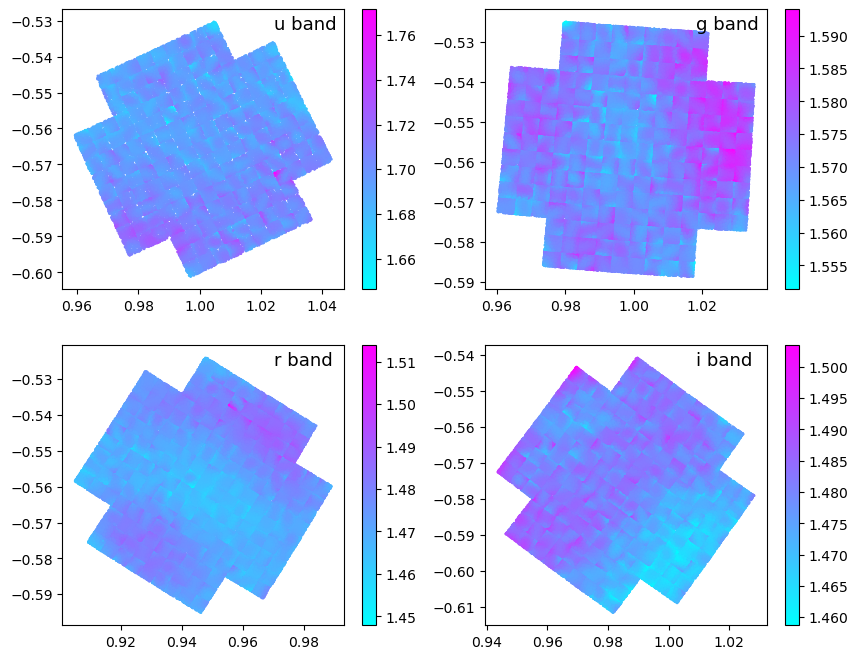

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for i,v in enumerate([760255, 1169217, 908959, 951283]):
    if i <= 1: j=0
    else: j=1
    
    dataId = {'visit':v,'detector': 0} 
    ccd = butler.get('calexp', **dataId)
    band = ccd.getFilter().bandLabel
    
    ra, dec, psf_size = fullVisit_RADEC_Only_catalog(v,189)
    sc = ax[j,i%2].scatter(ra, dec, c = psf_size, s = 1, cmap = 'cool')
    plt.colorbar(sc, ax = ax[j,i%2])
    #plt.text(0.05, 0.93, "visit " + str(v) , color = 'k', fontsize=13, transform=ax[j,i%2].transAxes)
    plt.text(0.75, 0.93, band + " band", color = 'k', fontsize=13, transform=ax[j,i%2].transAxes) 


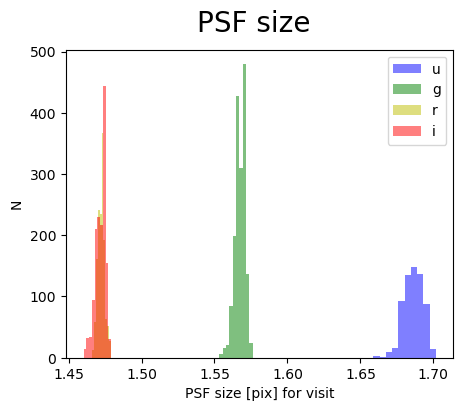

In [18]:
#bins = np.arange(1.7, 2.15, 0.012)
col = {"u": "b", "g": "g", "r": "y", "i": "r"}

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("PSF size", fontsize=20)


for i,v in enumerate([760255, 1169217, 908959, 951283]):
    dataId = {'visit':v,'detector': 0} 
    ccd = butler.get('calexp', **dataId)
    band = ccd.getFilter().bandLabel
    
    ra, dec, psf_size = fullVisit_RADEC_Only_catalog(v,3)
    ax.hist(psf_size, alpha=0.5, color = col[band], label=band)

ax.set_xlabel('PSF size [pix] for visit')
ax.set_ylabel('N')
plt.legend()

-------

## 3. Coaaded figures (selected by patches covering a similar area)

Select the patches and tracts (7x7patches) for a given RADEC and radius

In [19]:
my_ra_deg = 55.745834
my_dec_deg = -32.269167
radius = "0.5"

use_center_coords = str(my_ra_deg)+", " + str(my_dec_deg)

query = "SELECT tract, patch,count(*)" + \
        "FROM dp02_dc2_catalogs.Object " + \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), " + \
        "CIRCLE('ICRS', " + use_center_coords + ", " + radius + ")) = 1 " + \
        "GROUP BY tract,patch"

results = service.search(query).to_table().to_pandas()

In [20]:
results.head()

,tract,patch,count
0,4226,42,5318
1,4227,47,7410
2,4227,48,12438
3,4431,1,12615
4,4431,2,35542


In [21]:
def patch_PSFsize(f):
    ra, dec, psf_size = [],[],[]
    
    for i in range(len(results)):
        dataId = {'band': f, 'tract': results['tract'][i], 'patch': results['patch'][i]}
        ima = butler.get('deepCoadd', dataId=dataId)
        obj = butler.get('objectTable', **dataId)
        point_sources = obj[obj['refExtendedness'] == 0]
    
        for j in range(len(point_sources)):
            ra.append(point_sources['coord_ra'].iloc[j])
            dec.append(point_sources['coord_dec'].iloc[j])
            psf_size.append(np.sqrt((point_sources[f +'_ixxPSF'].iloc[j] + point_sources[f +'_iyyPSF'].iloc[j]) / 2.))
        
    return np.asarray(ra), np.asarray(dec), np.asarray(psf_size) 


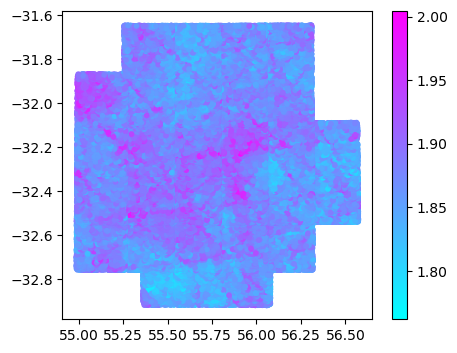

In [22]:
fig= plt.figure(figsize=(5,4))
ax = plt.gca()

ra, dec, psf_size = patch_PSFsize('g')
sc = ax.scatter(ra, dec, c=psf_size, s=10, cmap='cool')
plt.colorbar(sc, ax = ax)

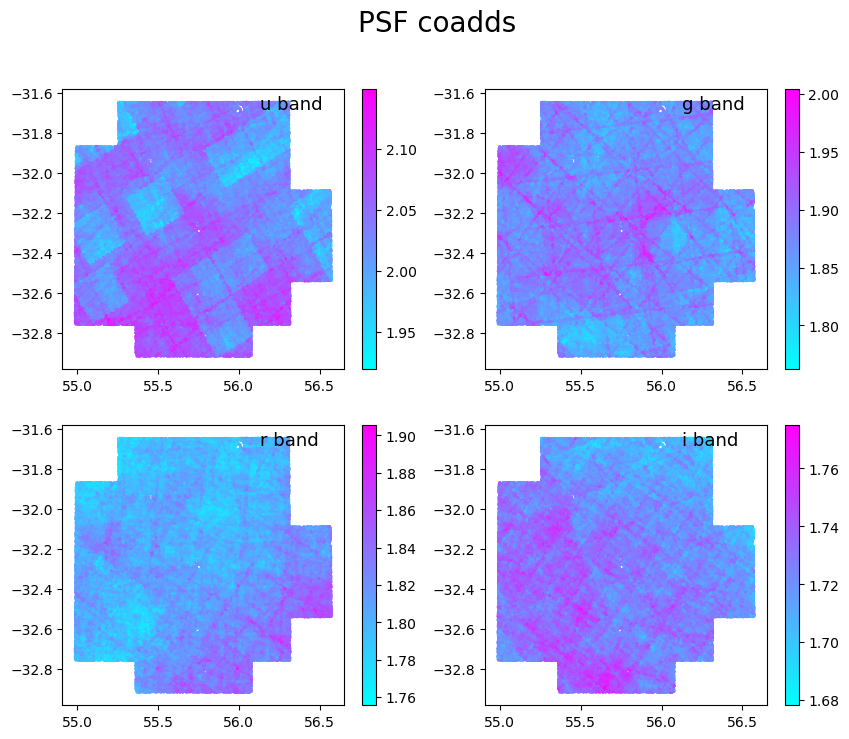

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle("PSF coadds", fontsize=20)

for i,b in enumerate("ugri"):
    if i <= 1: j=0
    else: j=1
    ra, dec, psf_size = patch_PSFsize(b)
    sc = ax[j,i%2].scatter(ra, dec, c = psf_size, s = 1, cmap = 'cool')
    plt.colorbar(sc, ax = ax[j,i%2])
    plt.text(0.7, 0.93, b + " band", color = 'k', fontsize=13, transform=ax[j,i%2].transAxes)


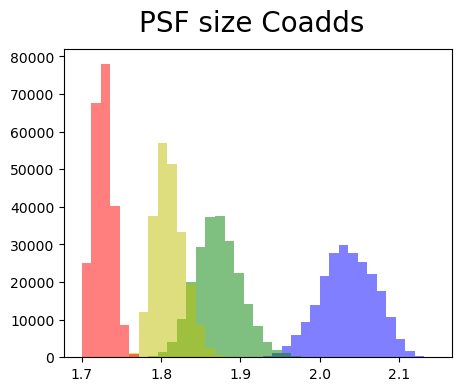

In [24]:
bins = np.arange(1.7, 2.15, 0.012)

fig, ax = plt.subplots(figsize=(5, 4))
fig.suptitle("PSF size Coadds", fontsize=20)

col = {"u": "b", "g": "g", "r": "y", "i":"r"}
for i,b in enumerate("ugri"):
    ra, dec, psf_size = patch_PSFsize(b)
    ax.hist(psf_size, bins, alpha=0.5, color = col[b], label=b)
